# Visium HD Multi-sample Analysis in Python: a Tutorial in Google Colab

*Note: 10x Genomics does not provide support for community-developed tools and makes no guarantees regarding their function or performance. Please contact tool developers with any questions.*

##How to Use This Google Colab
1. **Ensure Python 3 is the programming language and High RAM is enabled**. Navigate to `Runtime` > `Change runtime type` and check that *Runtime type* is set to `Python 3` and *Hardware accelerator* is set to `CPU` and `High RAM`. `High RAM` is required to process the data using Google Colab.

2. Click the **Connect** button in the top-right corner.

3. You can run the analysis using the provided datasets or load your own data by following the instructions at the beginning of each section.

If you wish to download and run the code locally instead of on the cloud, go to `File` > `Download` and select `Download .ipynb` for a notebook or `Download .py` for a Python script.

_Note: This Colab was developed with Google Colab Pro due to the size of the datasets. To run the code successfully, the High RAM option must be enabled. If you do not wish to upgrade to Google Colab Pro, it is recommended to download the code and run it locally._

# **Section 1: Python Environment Setup and Library Installation**

## **Python Libraries Used in this Analysis Guide**
This Analysis Guide will require the use of a few Python libraries. Some of the libraries are standard Python libraries like `gc` and `json`, but many of these libraries require installation.

* **[spatialdata](https://spatialdata.scverse.org/en/latest/index.html)** (as spd): A library for storing and manipulating multiomic spatial data. It can handle images, points, shapes (like polygons or circles), and tables (like `AnnData` objects). In the analysis, we import the `Identity` and `Scale` functions from `Spatialdata`'s `transformations` module.
* **[spatialdata_plot](https://github.com/scverse/spatialdata-plot)**: The plotting extension for `spatialdata`, enabling integrated visualization of images, shapes, and associated omics data.
* **[spatialdata_io](https://spatialdata.scverse.org/projects/io/en/latest/)** (as so): A sub-package of `spatialdata` designed for reading and writing various spatial omics file formats.
* **[geosketch](https://github.com/brianhie/geosketch)** (as sketch): A package used to downsample large datasets while preserving their underlying geometric structure and biological variability. This is a Python implementation of the algorithm described by *Hie et al. 2019*.
* **[numpy](https://numpy.org/)** (as np): This package provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
* **[pandas](https://pandas.pydata.org/)** (as pd): A library for data manipulation and analysis, providing data structures like DataFrames.
* **[scanpy](https://scanpy.readthedocs.io/en/stable/index.html)** (as sc): A toolkit for analyzing gene expression data installed with `Squidpy`, used for tasks such as preprocessing, dimensionality reduction (PCA, UMAP), clustering, and differential gene expression analysis.
* **scanpy.external** (as sce): A module within `Scanpy` that provides access to Harmonypy for batch correction. Harmonypy is a Python port of the R Harmony library used for dataset integration.
* **[json](https://docs.python.org/3/library/json.html)**: A standard Python library for importing and exporting JSON files. It is used in the creation of the `Spatialdata` object.
* **[gc](https://docs.python.org/3/library/gc.html)**: A standard Python library that provides an interface to the garbage collector that can help with memory management.
* **[geopandas](https://geopandas.org/en/stable/)** (as gpd): A library for working with geospatial vector data (like points, lines, and polygons).
* **spatialdata.models**: The functions imported from `spatialdata.models` library are used for defining and validating the structure and types of spatial data within the `Spatialdata` object.
* **[matplotlib.pyplot](https://matplotlib.org/stable/tutorials/pyplot.html)** (as plt): A Python package for data visualization.
* **[pydeseq2](https://pydeseq2.readthedocs.io/en/stable/)**: A Python implementation of the DESeq2 R library, used for differential gene expression analysis of count data. We import the `dds` and `ds` modules from the `pydeseq2` package.
* **[PIL](https://github.com/python-pillow/Pillow)**: A Python image processing package for opening, manipulating, and saving many images.
* **[shapely](https://pypi.org/project/shapely/)**: A Python package for manipulating and analyzing geometric objects. We import the `Polygon` module from the `shapely.geometry` module.

---

## **Installing Required Python Libraries to the Python Environment**
If you are not running the code using Google Colab, we recommend creating a fresh Python environment. In this guide, we use the Python package manager `uv` to install the required libraries.

To set up a local Python environment, follow these steps:

**Create a virtual environment (recommended):**

```python -m venv myenv```

**Activate the environment:**

```source myenv/bin/activate```


**Install required packages:**

```
(myenv) $ pip install --upgrade pip
(myenv) $ pip install  anndata==0.12.0 pydeseq2==0.5.2 squidpy==1.6.5 spatialdata==0.4.0 "spatialdata[extra]" geosketch==1.3 harmonypy==0.0.10 igraph==0.11.8
```

The Python script in this guide was written with Python v3.10 and the `spatialdata[extra]` package, which includes `spatialdata-io` v0.2.0 and `spatialdata-plot` v0.2.10.

If you are using Google Colab, execute each code cell to run the analysis.

## **Library Import**
Now that we have installed all required libraries, we import the necessary libraries.

*Note: If the error message `FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.11/dist-packages/xarray-2025.3.1.dist-info/METADATA'`, is displayed after running the next code cell, execute the code cell again.*

In [4]:
import spatialdata as spd
import spatialdata_plot as splt
import spatialdata_io as so
import geosketch as sketch
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce

import json
import gc
import geopandas as gpd
from spatialdata.models import Image2DModel, TableModel, ShapesModel
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from PIL import Image
from spatialdata.transformations import Identity, Scale
from shapely.geometry import Polygon


## **Helper Functions**
We use two custom helper function in this guide, which are defined in the next set of code cells.

The function `create_zarr` takes the raw output files from 10x Genomics' Visium HD processing and structures them into a single Zarr file, making the data ready for spatial analysis using libraries like `spatialdata`. It takes input paths, loads and prepares data, defines coordinate systems and transformations, processes the cell segmentation, integrates it with the `AnnData` object, creates `SpatialData` elements, and writes all of this to a Zarr file.

It takes five inputs:
* **`image_path`**: The path to the image file.
* **`count_matrix_path`**: The path to the cell segmentation filtered feature-barcode count matrix file.
* **`scale_factors_path`**: The path to the scale factors JSON file.
* **`geojson_path`**: The path to the cell segmentation GeoJSON file.
* **`sample_name`**: A name for the Zarr output file.

In this guide, we use the `hires_image.png` file to reduce the size of the Zarr file and the RAM requirement, which speeds up the code. The full-resolution microscope image can also be used, with adjustments to the code to properly scale the cell segmentation GeoJSON file. The images required in the final Zarr file will depend on the downstream analyses.

In [19]:
def create_zarr(count_matrix_path,
                image_path,
                scale_factors_path,
                geojson_path,
                sample_name
):
    print(sample_name)

    # Load and Prepare Raw Data
    # Define file paths
    COUNT_MATRIX_PATH = count_matrix_path
    IMAGE_PATH = image_path
    SCALE_FACTORS_PATH = scale_factors_path
    GEOJSON_PATH = geojson_path

    # Load AnnData
    adata = sc.read_10x_h5(COUNT_MATRIX_PATH)
    adata.var_names_make_unique()
    adata.obs['sample'] = sample_name
    adata.obs.index = sample_name +"_" + adata.obs.index.astype(str)

    # Load and preprocess image data
    image_data = np.array(Image.open(IMAGE_PATH))
    if image_data.ndim == 2:
        image_data = image_data[np.newaxis, :, :] # Add channel dimension for grayscale
    elif image_data.ndim == 3:
        image_data = np.transpose(image_data, (2, 0, 1)) # (H, W, C) -> (C, H, W) for spatialdata

    # Load scale factors
    with open(SCALE_FACTORS_PATH, 'r') as f:
        scale_data = json.load(f)

    # Load GeoJSON data
    with open(GEOJSON_PATH, 'r') as f:
        geojson_data = json.load(f)

    # Define coordinate systems:
    # `downscale_to_hires`: The coordinate system where shapes are located, scaled relative to the hires resolution.

    hires_scale = scale_data['tissue_hires_scalef']

    # Transformation for shapes (from pixel to downscale_to_hires)
    shapes_transformations = {
       "downscale_to_hires": Scale(np.array([hires_scale, hires_scale]), axes=("x", "y")) # if the high-resolution microscope image is being used and Identity() transform would be performed.
    }

    # Transformation for the 'hires_tissue_image' (it's already in the 'downscale_to_hires' space visually)
    image_transformations = {
        "downscale_to_hires": Identity()
    }

    # Process Cell Segmentation (GeoJSON) and Integrate with AnnData

    # Create a mapping from adata.obs.index to geojson features
    geojson_features_map = {
        f"{sample_name}_cellid_{feature['properties']['cell_id']:09d}-1": feature
        for feature in geojson_data['features']
    }

    # Prepare data for GeoDataFrame and update adata.obs
    geometries = []
    cell_ids_ordered = []

    for obs_index_str in adata.obs.index:
        feature = geojson_features_map.get(obs_index_str)
        if feature:
            # Create shapely Polygon from coordinates
            polygon_coords = np.array(feature['geometry']['coordinates'][0])
            geometries.append(Polygon(polygon_coords))
            cell_ids_ordered.append(obs_index_str)
        else:
            geometries.append(None) # Or a suitable placeholder
            cell_ids_ordered.append(obs_index_str)

    # Remove None entries if any (or handle them upstream)
    valid_indices = [i for i, geom in enumerate(geometries) if geom is not None]
    geometries = [geometries[i] for i in valid_indices]
    cell_ids_ordered = [cell_ids_ordered[i] for i in valid_indices]


    # Create GeoDataFrame for shapes
    shapes_gdf = gpd.GeoDataFrame({
        'cell_id': cell_ids_ordered,
        'geometry': geometries
    }, index=cell_ids_ordered)
    # Update adata.obs with cluster information and spatial identifiers
    adata.obs['cell_id'] = adata.obs.index
    adata.obs['region'] = sample_name + '_cell_boundaries'
    adata.obs['region'] = adata.obs['region'].astype('category')
    adata = adata[shapes_gdf.index].copy() # Filter adata to match shapes_gdf

    # Define names for SpatialData elements
    IMAGE_KEY =  sample_name + '_hires_tissue_image'
    TABLE_KEY =  'segmentation_counts'
    SHAPES_KEY = sample_name + '_cell_boundaries'

    # Create SpatialData elements directly
    sdata = spd.SpatialData(
        images={
            IMAGE_KEY: Image2DModel.parse(image_data, transformations=image_transformations)
        },
        tables={
            TABLE_KEY: TableModel.parse(
                adata,
                region=SHAPES_KEY, # Link table to shapes element
                region_key='region', # Column in adata.obs indicating region name
                instance_key='cell_id' # Column in adata.obs with instance IDs (cell_id)
            )
        },
        shapes={
            SHAPES_KEY: ShapesModel.parse(shapes_gdf, transformations=shapes_transformations)
        }
    )

    sdata.write(sample_name, overwrite=True)
    del sdata
    gc.collect()




If you want to use the square-bin outputs instead of the segmentation-based bin outputs, you can use the `so.visium_hd` function from `spatialdata` version 0.4.0. This simplifies the `create_zarr` function, as seen in this code:

```
def create_zarr(
                path_to_outputs,
                zarr_name,
                bin_size
):
    print(zarr_name)
    sdata = so.visium_hd(path=path_to_outputs,
                         load_all_images=True, bin_size=bin_size)
    sdata.write(zarr_name, overwrite=True)
    del sdata
```

Starting with  `spatialdata-io` version 0.5.0, you can directly import the segmentation results using the  `so.visium_hd` function. If you prefer this approach, the code would be:

In [11]:
# def create_zarr(
#                 path_to_outputs,
#                 zarr_name,
#                 bin_size
# ):
#     print(zarr_name)
#     sdata = so.visium_hd(path=path_to_outputs,
#                          load_all_images=True,
#    load_segmentations_only=True,
#    			        load_nucleus_segmentations=True,
# )
#     sdata.write(zarr_name, overwrite=True)
#     del sdata

Please note that using the `so.visium_hd` function will result in different names in the `SpatialData` object for the image, shapes, tables, and coordinate systems, requiring corresponding adjustments to the code.

The second helper function `crop0` ensures that the images generated from the analysis are cropped to the region of interest, aligning with the Visium HD Capture Area of each sample. It takes as input a `SpatialData` object (`x`), a target coordinate system (`crs`), and a bounding box dictionary (`bbox`). A bounding box dictionary is a way to represent a rectangular region in a 2D space using a Python dictionary. It typically contains the minimum and maximum coordinates for both the x and y axes that define the boundaries of the box. The function assumes that the `bbox` dictionary was created using `spd.get_extent` with the same coordinate system. Internally, the function calls `spd.bounding_box_query` and uses the minimum and maximum coordinates from the dictionary to subset the data from the `SpatialData` object that falls within this defined rectangle. This ensures that subsequent visualizations or analyses are focused only on the relevant part of the data. This is required because the microscope image is often larger than the Visium HD Gene Expression capture area.

In [7]:
def crop0(x,crs,bbox):
    return spd.bounding_box_query(
        x,
        min_coordinate=[bbox['x'][0], bbox['y'][0]],
        max_coordinate=[bbox['x'][1], bbox['y'][1]],
        axes=("x", "y"),
        target_coordinate_system=crs,
    )

#**Section 2. Data Download Links**



The datasets used in this Analysis Guide are publicly available from 10x Genomics:

[Human Colon Cancer and Normal Adjacent Datasets](https://www.10xgenomics.com/products/visium-hd-spatial-gene-expression/dataset-human-crc)



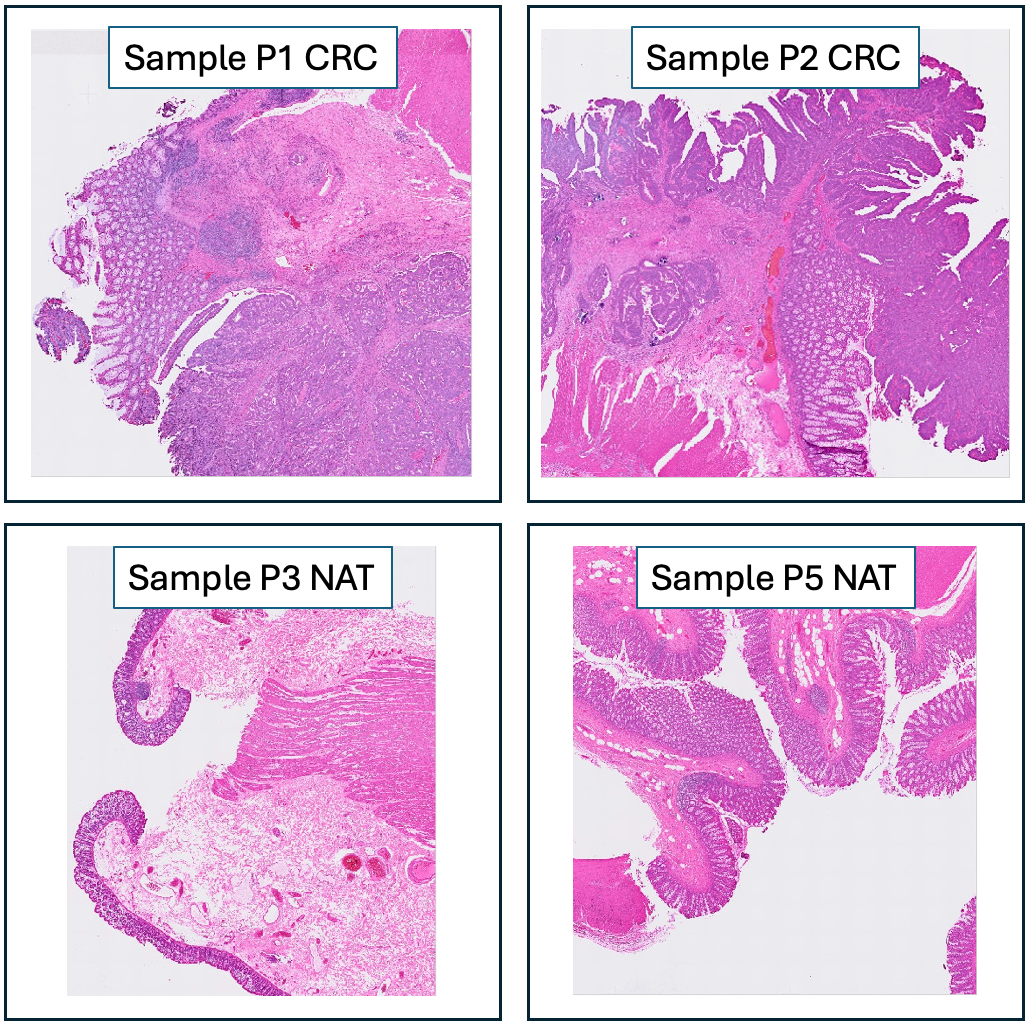


The specific datasets used in this guide are:
* **Visium HD, Sample P1 Colon Cancer (CRC)**: Human colon cancer tissue (Patient 1).
* **Visium HD, Sample P2 CRC**: Human colon cancer tissue (Patient 2).
* **Visium HD, Sample P3 Normal Adjacent Tissue (NAT)**: Normal adjacent human colon tissue (Patient 3).
* **Visium HD, Sample P5 NAT**: Normal adjacent human colon tissue (Patient 5).

If you are working with your own data, for each dataset, the `outs` directory will contain the cell segmentation based binned output and spatial output data. For a more detailed description of Visium HD's outputs, see the documentation on our support [site](https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/output-overview).

The data was originally processed using `spaceranger count` v3.0.0. However, to generate the Space Ranger cell segmentation outputs used in this guide, the public colon cancer and normal adjacent tissue datasets were reprocessed using `spaceranger count` v4.0.1.

The next code cell downloads and extracts the data required to make the spatial Zarr files and `SpatialData` objects.

In [15]:
! pwd

/Users/jmakings/Documents/Projects/visiumhd/notebooks


In [18]:
%%capture
%cd ../data/raw/
# !wget https://cf.10xgenomics.com/supp/spatial-exp/analysis-workshop/multisample_raw_data.tar.gz
!curl -L -O https://cf.10xgenomics.com/supp/spatial-exp/analysis-workshop/multisample_raw_data.tar.gz
!tar xvzf multisample_raw_data.tar.gz
!rm multisample_raw_data.tar.gz

# **Section 3: Conversion of Space Ranger Output to Zarr Format and SpatialData Object Creation**

We begin this section by converting the standard Visium HD output into a Zarr file, as the `spatialdata` library expects data in this format. If you are running this code locally, this code needs to be run only once, as the datasets can be loaded directly from the saved Zarr files afterward.

In the following code snippet, a dictionary is created where each sample name serves as a unique key. The value associated with each key is a list containing:
* the path and filename of the filtered feature-cell matrix in `h5` format.
* the location and name of the image to be stored in the `SpatialData` object.
* the scale factors JSON file, so that the cell segmentation results can beoverlaid onto the tissue image.
* the cell segmentation GeoJSON file, so the cell segmentation results can be visualized on the tissue image.
* the desired name for the Zarr file.

Each key-value pair in this dictionary is then processed by the `create_zarr` helper function. For this specific example, we only use the `tissue_hires_image.png`. Other images, such as a high-resolution microscope image or CytAssist image, can be added to the `SpatialData` object.


In [20]:
# Create and save Zarr files for the cell segmentation outputs.
samples = {
    "Colon_Cancer_P1":["data/Cancer_P1_filtered_feature_cell_matrix.h5",
                      "data/Cancer_P1_tissue_hires_image.png",
                      "data/Cancer_P1_scalefactors_json.json",
                      "data/Cancer_P1_cell_segmentations.geojson",
                      "Colon_Cancer_P1"],
    "Colon_Cancer_P2":["data/Cancer_P2_filtered_feature_cell_matrix.h5",
                      "data/Cancer_P2_tissue_hires_image.png",
                      "data/Cancer_P2_scalefactors_json.json",
                      "data/Cancer_P2_cell_segmentations.geojson",
                      "Colon_Cancer_P2"],
    "Colon_Normal_P3":["data/Norm_P3_filtered_feature_cell_matrix.h5",
                      "data/Norm_P3_tissue_hires_image.png",
                      "data/Norm_P3_scalefactors_json.json",
                      "data/Norm_P3_cell_segmentations.geojson",
                      "Colon_Normal_P3"],
    "Colon_Normal_P5":["data/Norm_P5_filtered_feature_cell_matrix.h5",
                      "data/Norm_P5_tissue_hires_image.png",
                      "data/Norm_P5_scalefactors_json.json",
                      "data/Norm_P5_cell_segmentations.geojson",
                      "Colon_Normal_P5"],
}
print("Saving zarr files")
for key, inputs in samples.items():
    create_zarr(count_matrix_path=inputs[0],
                image_path=inputs[1],
                scale_factors_path=inputs[2],
                geojson_path=inputs[3],
                sample_name=inputs[4])

del samples, inputs, key
gc.collect()

Saving zarr files
Colon_Cancer_P1


/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     The Zarr backing store has been changed from None the new file path: Colon_Cancer_P1                      
Colon_Cancer_P2


/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     The Zarr backing store has been changed from None the new file path: Colon_Cancer_P2                      
Colon_Normal_P3


/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     The Zarr backing store has been changed from None the new file path: Colon_Normal_P3                      
Colon_Normal_P5


/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     The Zarr backing store has been changed from None the new file path: Colon_Normal_P5                      


0

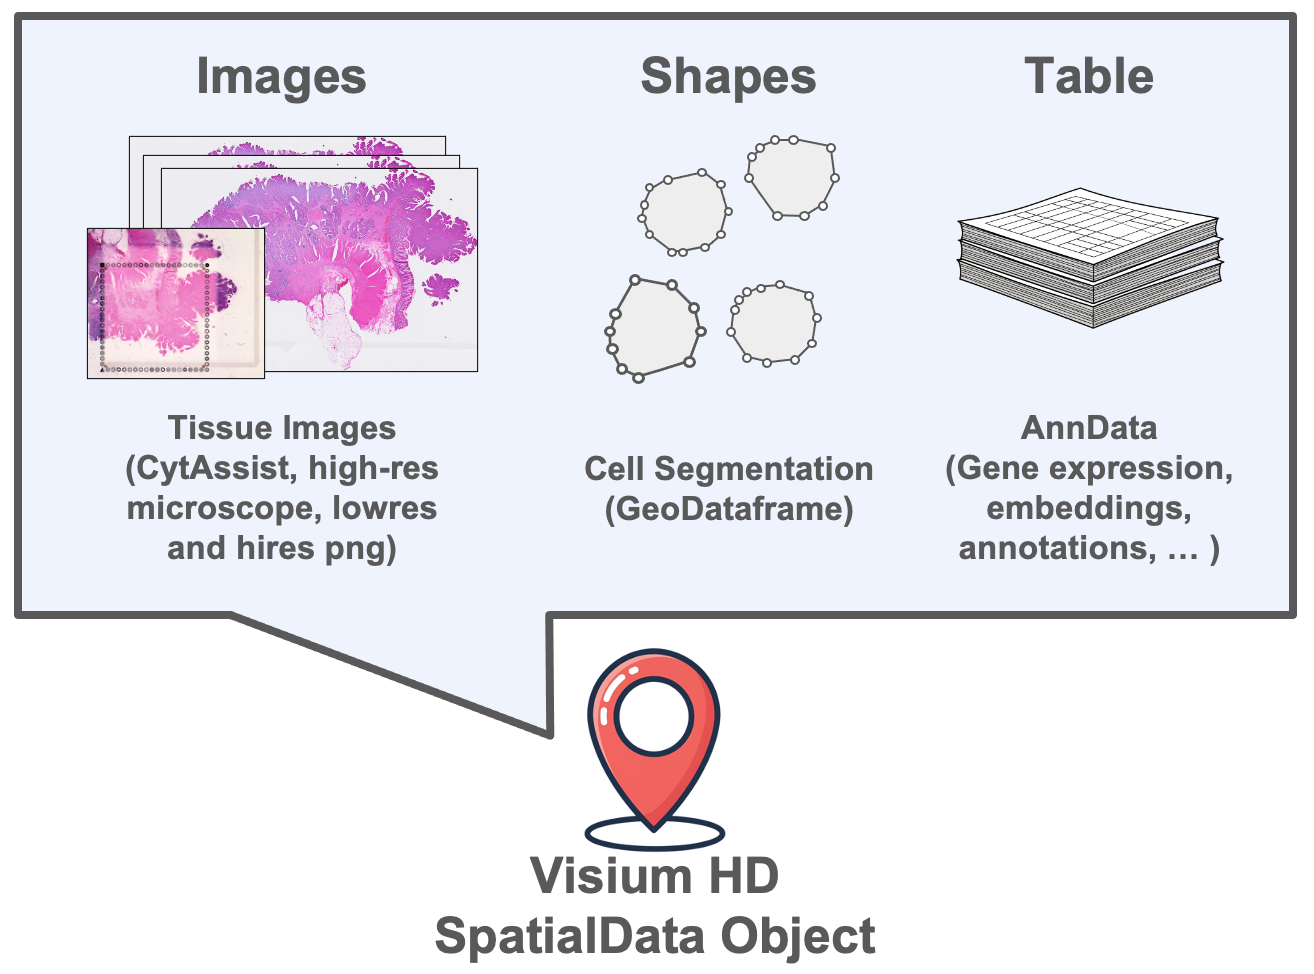


## **The SpatialData Object and Its Components**
The `spatialdata` library is built to manage and analyze multiomic spatial datasets. It brings together multiple data types into a single, unified `SpatialData` object. These objects act as on-disk containers that utilize the Zarr file format to store various **Elements** or data types.
A `SpatialData` object created from Visium HD data typically has the following Elements:
* **Images**: CytAssist and microscopy images (e.g., H&E, fluorescence) providing spatial context. These can be accessed via `sdata.images`.
* **Shapes**: Geometric annotations such as polygons or circles representing regions of interest, cells, or spots. In Visium HD, these often represent binned regions or cell segmentations. These are accessible via `sdata.shapes`.
* **Tables**: An `AnnData` object associated with the spatial elements, typically containing gene expression data, cellular metadata, and computational results (e.g., clusters, UMAP embeddings). This Element is used for downstream analyses and is accessed via `sdata.tables`. Each `AnnData` table within `sdata.tables` has:
  * `.X`: The primary data matrix (e.g., raw counts, normalized counts).
  * `.obs`: Observation metadata (e.g., sample ID, cluster assignments).
  * `.var`: Variable metadata (e.g., gene names).
  * `.obsm`: Multi-dimensional annotations (e.g., PCA, UMAP embeddings).
  * `.layers`: Alternative representations of `.X`.

In the next code block, the `SpatialData` object is created from the Zarr files. Each Zarr file is read into a list of `SpatialData` objects using the `read_zarr` function before the objects are concatenated. In addition, a `sample` column is added to each `AnnData` table within the `SpatialData` object, and the `var_names_make_unique` function is used to ensure that gene names are unique.


In [21]:
%%time

# Loading the zarr files
visium_hd_zarr_paths = {
    "Cancer_P1": "./Colon_Cancer_P1",
    "Cancer_P2": "./Colon_Cancer_P2",
    "Normal_P3": "./Colon_Normal_P3",
    "Normal_P5": "./Colon_Normal_P5"
}


# Loading samples into a dictionary
sdatas = []
for key, path in visium_hd_zarr_paths.items():
    sdata = spd.read_zarr(path)

    for table in sdata.tables.values():
        table.var_names_make_unique()
        table.obs["sample"] = key

    sdatas.append(sdata)
    del sdata, table
    gc.collect()
# Concatenate
concatenated_sdata = spd.concatenate(sdatas, concatenate_tables=True)

concatenated_sdata.write("concatenated_sdata", overwrite=True)

del concatenated_sdata,sdatas,visium_hd_zarr_paths, key, path
gc.collect()

concatenated_sdata = spd.read_zarr("concatenated_sdata")

print("---------------------------------")
print(concatenated_sdata)

version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/zarr/creation.p

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside concatenated_sdata). Please see the documentation of `is_self_contained()` to understand
         the implications of working with SpatialData objects that are not self-contained.                         
INFO     The Zarr backing store has been changed from None the new file path: concatenated_sdata                   


version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/jmakings/miniforge3/envs/visiumhd/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04
version mismatch: detected: RasterFormatV02, requested: FormatV04


---------------------------------
SpatialData object, with associated Zarr store: /Users/jmakings/Documents/Projects/visiumhd/data/raw/concatenated_sdata
├── Images
│     ├── 'Colon_Cancer_P1_hires_tissue_image': DataArray[cyx] (3, 4961, 6000)
│     ├── 'Colon_Cancer_P2_hires_tissue_image': DataArray[cyx] (3, 3886, 6000)
│     ├── 'Colon_Normal_P3_hires_tissue_image': DataArray[cyx] (3, 3168, 6000)
│     └── 'Colon_Normal_P5_hires_tissue_image': DataArray[cyx] (3, 4153, 6000)
├── Shapes
│     ├── 'Colon_Cancer_P1_cell_boundaries': GeoDataFrame shape: (217952, 2) (2D shapes)
│     ├── 'Colon_Cancer_P2_cell_boundaries': GeoDataFrame shape: (220404, 2) (2D shapes)
│     ├── 'Colon_Normal_P3_cell_boundaries': GeoDataFrame shape: (75526, 2) (2D shapes)
│     └── 'Colon_Normal_P5_cell_boundaries': GeoDataFrame shape: (138374, 2) (2D shapes)
└── Tables
      └── 'segmentation_counts': AnnData (652256, 18085)
with coordinate systems:
    ▸ 'downscale_to_hires', with elements:
        Colon_Can

The concatenated `SpatialData` object (`concatenated_sdata`) contains:
* four images (the `hires_tissue_image.png` for each sample), each with its corresponding coordinate system.
* four shapes, which are `GeoDataFrame` representations of the cell segmentation bins.
* one table that holds the cell segmentation bin gene expression data along with its metadata.

Using Sample P1 CRC as an example, the `SpatialData` object contains the following Elements:
* **Images**:
  * `Colon_Cancer_P1_hires_tissue_image`: This is the high-resolution version of the downsampled PNG image, associated with the `downscale_to_hires` coordinate system.
* **Shapes**:
  * `Colon_Cancer_P1_cell_boundaries`: This represents the spatial information (shape and location) for the cell segmentation bins.
* **Tables**:
  * `segmentation_counts`: This table contains the gene expression data and associated metadata for the cell segmentation bins.

In this guide, the hires PNG images from the Visium HD output folder are used with the `downscale_to_hires` coordinate system. For more information on `SpatialData` objects, see `scverse`'s introductory [tutorials](https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/intro.html).


In [22]:
concatenated_sdata

SpatialData object, with associated Zarr store: /Users/jmakings/Documents/Projects/visiumhd/data/raw/concatenated_sdata
├── Images
│     ├── 'Colon_Cancer_P1_hires_tissue_image': DataArray[cyx] (3, 4961, 6000)
│     ├── 'Colon_Cancer_P2_hires_tissue_image': DataArray[cyx] (3, 3886, 6000)
│     ├── 'Colon_Normal_P3_hires_tissue_image': DataArray[cyx] (3, 3168, 6000)
│     └── 'Colon_Normal_P5_hires_tissue_image': DataArray[cyx] (3, 4153, 6000)
├── Shapes
│     ├── 'Colon_Cancer_P1_cell_boundaries': GeoDataFrame shape: (217952, 2) (2D shapes)
│     ├── 'Colon_Cancer_P2_cell_boundaries': GeoDataFrame shape: (220404, 2) (2D shapes)
│     ├── 'Colon_Normal_P3_cell_boundaries': GeoDataFrame shape: (75526, 2) (2D shapes)
│     └── 'Colon_Normal_P5_cell_boundaries': GeoDataFrame shape: (138374, 2) (2D shapes)
└── Tables
      └── 'segmentation_counts': AnnData (652256, 18085)
with coordinate systems:
    ▸ 'downscale_to_hires', with elements:
        Colon_Cancer_P1_hires_tissue_image (Images)

# **Section 4: Quality Control and Filtering**

The analysis begins by removing low-quality cell segmentation bins from the datasets. In this example, this is done by visualizing the total UMI distribution to estimate a suitable cutoff for empty or sparsely populated bins. Even though mitochondrial content is calculated, it is not used as a filtering criterion, as high levels of mitochondrial genes can be biologically relevant in spatial data.


In [23]:
adata = concatenated_sdata["segmentation_counts"] # we link the AnnData Table in the SpatialData object to the variable adata to make the code easier to read
adata

AnnData object with n_obs × n_vars = 652256 × 18085
    obs: 'sample', 'cell_id', 'region'
    uns: 'spatialdata_attrs'

In [24]:
adata.obs

,sample,cell_id,region
Colon_Cancer_P1_cellid_000000002-1,Cancer_P1,Colon_Cancer_P1_cellid_000000002-1,Colon_Cancer_P1_cell_boundaries
Colon_Cancer_P1_cellid_000000003-1,Cancer_P1,Colon_Cancer_P1_cellid_000000003-1,Colon_Cancer_P1_cell_boundaries
Colon_Cancer_P1_cellid_000000006-1,Cancer_P1,Colon_Cancer_P1_cellid_000000006-1,Colon_Cancer_P1_cell_boundaries
Colon_Cancer_P1_cellid_000000008-1,Cancer_P1,Colon_Cancer_P1_cellid_000000008-1,Colon_Cancer_P1_cell_boundaries
Colon_Cancer_P1_cellid_000000009-1,Cancer_P1,Colon_Cancer_P1_cellid_000000009-1,Colon_Cancer_P1_cell_boundaries
...,...,...,...
Colon_Normal_P5_cellid_000171052-1,Normal_P5,Colon_Normal_P5_cellid_000171052-1,Colon_Normal_P5_cell_boundaries
Colon_Normal_P5_cellid_000171076-1,Normal_P5,Colon_Normal_P5_cellid_000171076-1,Colon_Normal_P5_cell_boundaries
Colon_Normal_P5_cellid_000171082-1,Normal_P5,Colon_Normal_P5_cellid_000171082-1,Colon_Normal_P5_cell_boundaries
Colon_Normal_P5_cellid_000171083-1,Normal_P5,Colon_Normal_P5_cellid_000171083-1,Colon_Normal_P5_cell_boundaries


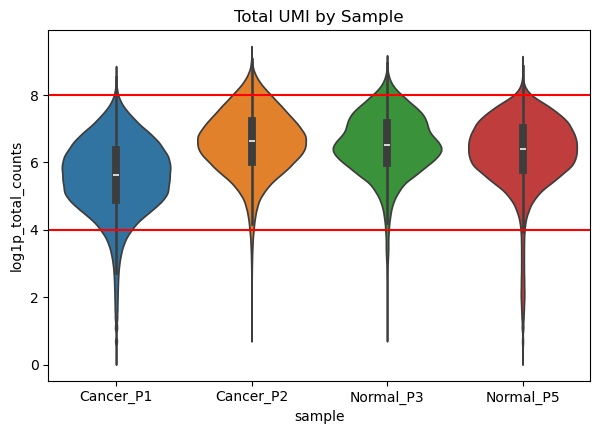

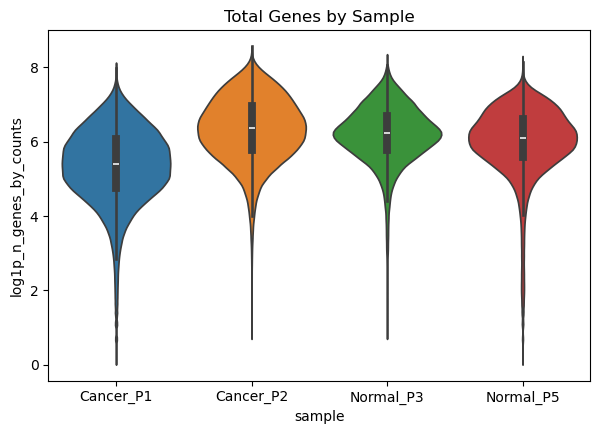

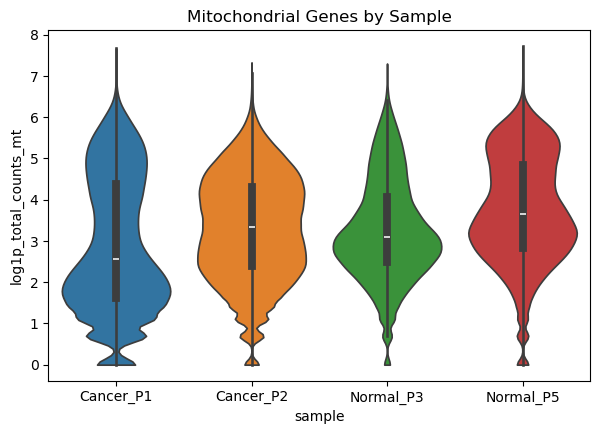

In [25]:
# Add mitochondrial gene calculation for QC
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True, percent_top=None)


# Visualization for QC
sc.pl.violin(adata=adata, keys=["log1p_total_counts"], stripplot=False, inner="box",show=False, groupby="sample",)
plt.title("Total UMI by Sample")
plt.axhline(y=4, color='r', linestyle='-')
plt.axhline(y=8, color='r', linestyle='-')
plt.title("Total UMI by Sample")
plt.show()

sc.pl.violin(adata=adata, keys=["log1p_n_genes_by_counts"], groupby="sample", stripplot=False, inner="box",show=False)
plt.title("Total Genes by Sample")
plt.show()

sc.pl.violin(adata=adata, keys=["log1p_total_counts_mt"], groupby="sample", stripplot=False, inner="box",show=False)
plt.title("Mitochondrial Genes by Sample")
plt.show()

plt.close('all')



Based on the log1p total UMI violin plot, cell segmentation bins with fewer than 53 counts (corresponding to a log1p value of 4) and more than 2,979 counts (corresponding to a log1p value of 8) are removed from the datasets using `Scanpy’`s `filter_cells` function. Additionally, genes present in fewer than 50 cell segmentation bins are excluded from the analysis using `Scanpy’`s `filter_genes` function. It is important to note that both the count cutoffs and the number of bins a gene must be present in will vary between experiments and should be determined empirically.

In this example, we filtered all the datasets using the same criteria. However, with a different set of datasets, the samples may need to be filtered using sample-specific criteria.



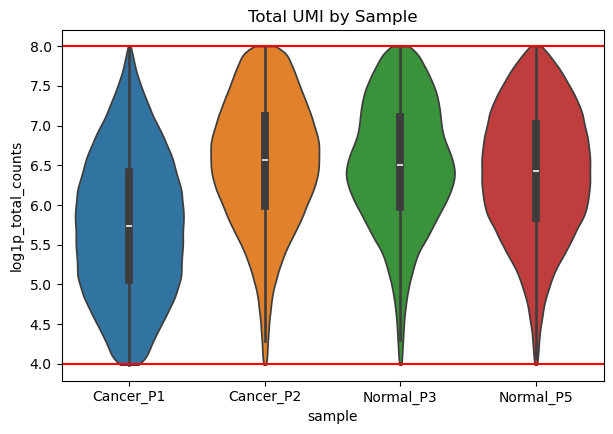

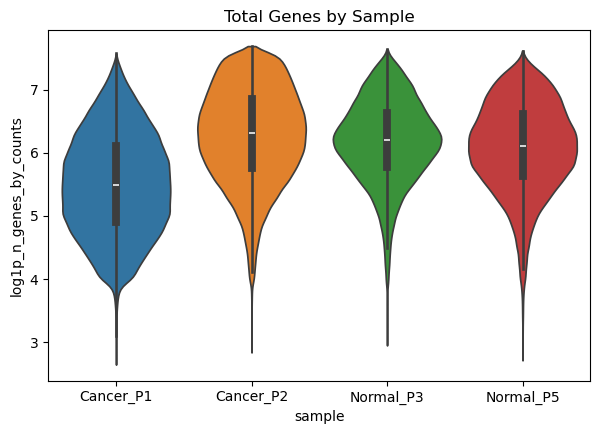

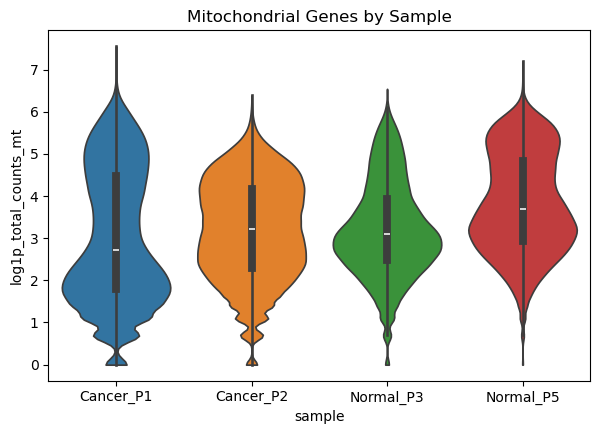

64417

In [26]:

# Estimating the cut off
min_counts = np.expm1(4).astype("int")
max_counts = np.expm1(8).astype("int")

# Filtering genes and cells
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_cells(adata, min_counts=min_counts)
sc.pp.filter_cells(adata, max_counts=max_counts)

# Visualization for QC
sc.pl.violin(adata=adata, keys=["log1p_total_counts"], stripplot=False, inner="box",show=False, groupby="sample",)
plt.title("Total UMI by Sample")
plt.axhline(y=4, color='r', linestyle='-')
plt.axhline(y=8, color='r', linestyle='-')
plt.title("Total UMI by Sample")
plt.show()

sc.pl.violin(adata=adata, keys=["log1p_n_genes_by_counts"], groupby="sample", stripplot=False, inner="box",show=False)
plt.title("Total Genes by Sample")
plt.show()

sc.pl.violin(adata=adata, keys=["log1p_total_counts_mt"], groupby="sample", stripplot=False, inner="box",show=False)
plt.title("Mitochondrial Genes by Sample")
plt.show()

plt.close('all')

# storing filtered counts
adata.layers["filtered_counts"] = adata.X.copy()


del max_counts, min_counts
gc.collect()


*Note: A copy of the raw count data is saved in the filtered_counts layer for later use. It's crucial to use the `.copy()` method to ensure the raw count values are preserved.*


# **Section 5: Data Normalization and Dimensionality Reduction**
Now that the `SpatialData` object is filtered, we normalize the filtered counts and perform Principal Component Analysis (`PCA`) for dimensionality reduction using `Scanpy`'s `normalize_total`, `log1p`, and `pca` preprocessing functions. Before running PCA, there is an option to identify highly variable genes using `Scanpy`'s `highly_variable_genes` function, so that only these genes are used in the PCA. However, in practice, we prefer to use the entire gene set. You may wish to find highly variable genes and use them in your own analysis. In this analysis, we set the `target_sum` to `None`, so that after normalization, each cell segmentation bin has a total UMI count equal to the median of the total UMI count for all cell segmentation bins before normalization. By default, `Scanpy’`s `pca` function generates the first 50 principal components (PCs). The normalization and dimensionality reduction steps are performed on the `SpatialData` object without copying the `AnnData` object. The results are stored directly within the `sdata_concatenate` object as the `adata` variable is linked to it.

We also generate an Elbow plot of the data to ensure that sufficient variation is captured in downstream analyses. `Scanpy`'s functions, by default, will use all generated PCs unless specified otherwise. However, you may choose to restrict the number of PCs to prevent overfitting the data.


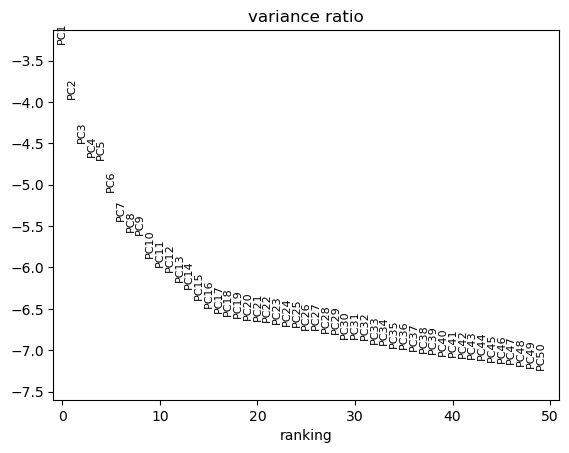

CPU times: user 1min 30s, sys: 5.63 s, total: 1min 36s
Wall time: 1min 38s


In [27]:
%%time

sc.pp.normalize_total(adata, target_sum = None)
sc.pp.log1p(adata)
sc.tl.pca(adata)

adata.write("preprocessed_adata.h5ad")

# Elbow plot
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)

# **Section 6: Clustering and UMAP Visualization**
Now that we have standardized the data and performed a PCA, we will cluster and visualize the results. `Scanpy`'s `neighbors` function generates a neighbor distance matrix and a neighborhood graph, which is used by `Scanpy`'s `leiden` function to cluster the data. Finally, `Scanpy`’s `umap` function is used to visualize the results.

## Extra Options
When running `Scanpy`'s `neighbors` function, the distance metric selected will impact the clustering results. Therefore, you may need to explore different metrics depending on your datasets. Common distance metrics available in `Scanpy` include:
* **Euclidean distance**: The straight-line distance between two points in multi-dimensional space. It tends to group cells with similar overall expression magnitudes. If some genes have very high expression, they can dominate the distance calculation.
* **Manhattan distance (L1 distance, City Block distance)**: The sum of the absolute differences of their coordinates. It is less sensitive to outliers than Euclidean distance. It is useful when differences in individual features are more important than overall magnitude.
* **Cosine distance/similarity**: Measures the angle between two vectors. A smaller angle (closer to 0) indicates higher similarity. It focuses on the orientation of the expression profiles, rather than their magnitude. This is particularly useful when the relative proportions of gene expression might be more informative than the absolute counts. Cell segmentation bins expressing the same genes in similar proportions will be considered close, even if one has a higher total count.
* **Correlation-based distances (e.g., Pearson, Spearman)**: These typically define distance as `1 - correlation_coefficient`. Cell segmentation bins are considered similar if their gene expression profiles are highly correlated, regardless of absolute expression values. This method identifies cell segmentation bins with similar patterns of gene activity.

A metric that emphasizes magnitude (like Euclidean) might connect cells based on overall transcriptional activity, while a metric emphasizing shape (like Cosine) might connect cells with similar gene expression patterns, even if their total RNA content differs.

For this analysis, we used `Scanpy`'s correlation distance metric, the clustering resolution (RES) is set to 0.8, and the number of neighbors is set to 15. These parameters will likely need to be fine-tuned for new analyses: a smaller resolution generally leads to fewer clusters, while increasing the number of neighbors will have a similar effect.

In addition, for optimal visualization, you may need to adjust the `min_dist` and `spread` parameters used in `Scanpy`'s umap function for Visium HD Gene Expression data. `min_dist` controls how tightly packed the points are in the final embedding, while `spread` determines the overall scale and the separation between clusters. These values will need to be empirically determined.

_Note: This is a time-consuming (20-30 min) process._

# *Note: Will skip this section and instead skip to batch correction, which is more complete*

In [29]:
# %%time

# # neighborhood and clustering resolution
# RES = 0.5 # clustering resolution
# NEIGHBORS = 30  # number of neighbors

# MIN_DIST=0.5 #default 0.5
# SPREAD=2 #default 1

# sc.pp.neighbors(adata, n_neighbors=NEIGHBORS, use_rep="X_pca",metric="correlation")
# sc.tl.leiden(adata, flavor="igraph", key_added="clusters", resolution=RES,random_state=0)

# # To ensure that the results are reproducible we are going to reorder the clusters by size.
# adata.obs['orig_clusters'] = adata.obs['clusters']

# clusters = adata.obs['clusters'].astype(int)

# # Count cells per cluster
# cluster_sizes = clusters.value_counts().sort_values(ascending=False)

# # Create mapping: old cluster ID → new ordered ID
# cluster_order = {old: new for new, old in enumerate(cluster_sizes.index)}

# # Relabel clusters in adata
# adata.obs['clusters'] = clusters.map(cluster_order).astype(str)

# # Set random_state for reproducible UMAP
# sc.tl.umap(adata,min_dist=MIN_DIST, spread=SPREAD, random_state=0)

# # Plot UMAP
# sc.pl.umap(adata, color=["clusters"], title="UMAP by Clusters")
# sc.pl.umap(adata, color=["sample"], title="UMAP by Sample")

# # Cell distribution across clusters
# sample_names = adata.obs["sample"].unique()
# plt.imshow(pd.crosstab(adata.obs["sample"], adata.obs["clusters"]), cmap='hot', interpolation='nearest')
# plt.title("Cell Distribution Across Clusters")
# plt.xlabel("Cluster")
# plt.yticks(range(len(sample_names)), sample_names)
# plt.show()
# plt.close('all')

# del RES, NEIGHBORS, MIN_DIST, SPREAD
# gc.collect()


We color the UMAP plot by sample identity to quickly check for any batch effects. There is not a clear separation in the sample clusters, as seen in the Analysis Guide, [Correcting Batch Effects in Visium Data](https://www.10xgenomics.com/analysis-guides/correcting-batch-effects-in-visium-data). In the above code block, we also generate a heatmap of the cross-tabulation between sample and cluster.

`pd.crosstab` creates a cross-tabulation (a frequency or contingency table) that counts the number of occurrences for each combination of categories—in this case, the samples and the clusters. The resulting table has samples as rows and clusters as columns, with each cell containing the count of cells that belong to a specific sample-cluster pair.

The heatmap generated from the cross-tabulation shows the frequency of cells in each cluster for each sample.

- **Rows:** Represent the different samples in your dataset.
- **Columns:** Represent the different clusters identified.
- **Color Intensity:** The color of each square indicates the number of barcodes. Darker colors (e.g., black) mean a low number of cells for that sample-cluster combination. Brighter colors (e.g., white or bright yellow) mean a high number of cells.

If the colors are relatively uniform across the rows, it suggests that each cluster is well-represented in all samples. This indicates that the clusters are not simply artifacts of a specific sample.

A bright spot in one row (sample) but not in others indicates that a particular cluster is highly enriched or unique to that specific sample. This could be due to a biological difference between samples or a batch effect. We know from the differential gene expression analysis that the bright spots in these datasets are tumor.

If a column is uniformly dark, it means that cluster is not present in any of the samples. If only one or two rows are dark, it suggests that cluster is absent in those specific samples.

In this particular dataset, a clear batch effect is not observed. However, in the next section, we demonstrate how `Harmony` can correct for batch effects if they were present. We also demonstrate how applying batch correction when a batch effect is not present can over-correct the data.

# **Section 7: Batch Correction (Optional)**
Sometimes a batch effect is present in the data. If one is observed, then `Harmony` can be used to correct the PCA embeddings to remove it. In the code, `Scanpy`'s preprocessing `harmony_integrate` function calls a Python implementation of the Harmony algorithm to perform this correction. For details on the algorithm, see the documentation for the R library implementation of [Harmony](https://cran.r-project.org/web/packages/harmony/vignettes/quickstart.html).

The sample column in the `AnnData` object is used as a key for the `harmony_integrate` function to differentiate between the various samples. Alternatively, if samples were processed in different batches, a dedicated batch column in the `AnnData` object could be used to group them by their processing batch. After the Harmony algorithm runs, the new PCA embeddings are copied over to the `X_pca` embeddings, and the original clustering results are saved. Subsequently, `Scanpy`'s `neighbors`, `leiden`, and `umap` functions are called to process the batch-corrected data.


In [ ]:
%%time

# neighborhood and clustering resolution
RES = 0.5 # clustering resolution
NEIGHBORS = 30  # number of neighbors

MIN_DIST=0.5 #default 0.5
SPREAD=2 #default 1

# Performing batch correction
adata_harmony = concatenated_sdata["segmentation_counts"].copy()
sce.pp.harmony_integrate(adata_harmony, key="sample", basis="X_pca",max_iter_harmony=20)

# Copying the harmony PCA embedding results
adata_harmony.obsm["X_pca_orig"] = adata_harmony.obsm["X_pca"]
adata_harmony.obsm["X_pca"] = adata_harmony.obsm["X_pca_harmony"]

# this line commented out because we skipped non-batch corrected clustering
#adata_harmony.obs["cluster_orig"] =  adata_harmony.obs["clusters"]

sc.pp.neighbors(adata_harmony, n_neighbors=NEIGHBORS, use_rep="X_pca",metric="correlation")
sc.tl.leiden(adata_harmony, flavor="igraph",key_added="harmony_clusters", resolution=RES,random_state=0)
adata_harmony.obs["clusters"] =  adata_harmony.obs["harmony_clusters"]

# Set random_state for reproducible UMAP
sc.tl.umap(adata_harmony,min_dist=MIN_DIST, spread=SPREAD, random_state=0)

# Plot UMAP
sc.pl.umap(adata_harmony, color=["clusters"], title="Harmony Corrected UMAP by Clusters")
sc.pl.umap(adata_harmony, color=["sample"], title="Harmony Corrected UMAP by Sample")

# Cell distribution across clusters
sample_names = adata_harmony.obs["sample"].unique()
plt.imshow(pd.crosstab(adata_harmony.obs["sample"], adata_harmony.obs["clusters"]), cmap='hot', interpolation='nearest')
plt.title("Cell Distribution Across Clusters")
plt.xlabel("Cluster")
plt.yticks(range(len(sample_names)), sample_names)
plt.show()
plt.close('all')


# If you want to use the harmony results in the analysis then overwrite the AnnData table in the SpatialData object by removing the comment below.
# concatenated_sdata["segmentation_counts"] = adata_harmony

del adata_harmony, RES, NEIGHBORS, MIN_DIST, SPREAD
gc.collect()